In [1]:
# # Colab execute.
# from google.colab import drive


# drive.mount('/content/drive')
# _path = '/content/drive/MyDrive/antenna-performance-prediction/antenna-performance-prediction'
# %cd /content/drive/MyDrive/antenna-performance-prediction/antenna-performance-prediction/

In [2]:
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
import time
from mylibrary import manipulation
from mylibrary import visualization as visual

# Local execute.
origin_train = pd.read_csv('dataset/train.csv')
origin_test = pd.read_csv('dataset/test.csv')
x_info = pd.read_csv('dataset/meta/x_feature_info.csv')
y_info = pd.read_csv('dataset/meta/y_feature_info.csv')
submission = pd.read_csv("dataset/sample_submission.csv")

# Colab execute.
# origin_train = pd.read_csv(f'{_path}/dataset/train.csv')
# origin_test = pd.read_csv(f'{_path}/dataset/test.csv')
# x_info = pd.read_csv(f'{_path}/dataset/meta/x_feature_info.csv')
# y_info = pd.read_csv(f'{_path}/dataset/meta/y_feature_info.csv')
# submission = pd.read_csv(f'{_path}/dataset/sample_submission.csv')


x_train = origin_train.filter(regex='X')
y_train = origin_train.filter(regex='Y')

x_test = origin_test.drop(columns=['ID'])

x_name = manipulation.make_namegroup(x_train, x_info)
y_name = manipulation.make_namegroup(y_train, y_info)

visual.print_namegroup(x_name)
print()
visual.print_namegroup(y_name)

PCB 체결 시 단계별 누름량(Step n): X_01  X_02  X_05  X_06
방열 재료 n 무게: X_03  X_10  X_11
n차 검사 통과 여부: X_04  X_23  X_47  X_48
방열 재료 n 면적: X_07  X_08  X_09
커넥터 위치 기준 좌표: X_12
각 안테나 패드 위치(높이) 차이: X_13
n번 안테나 패드 위치: X_14  X_15  X_16  X_17  X_18
n번 스크류 삽입 깊이: X_19  X_20  X_21  X_22
커넥터 n번 핀 치수: X_24  X_25  X_26  X_27  X_28  X_29
스크류 삽입 깊이n: X_30  X_31  X_32  X_33
스크류 체결 시 분당 회전수 n: X_34  X_35  X_36  X_37
하우징 PCB 안착부 n 치수: X_38  X_39  X_40
레이돔 치수 (안테나 n번 부위): X_41  X_42  X_43  X_44
안테나 부분 레이돔 기울기: X_45
실란트 본드 소요량: X_46
Cal 투입 전 대기 시간: X_49
RFn 부분 SMT 납 량: X_50  X_51  X_52  X_53  X_54  X_55  X_56

안테나 Gain 평균 (각도n): Y_01  Y_05  Y_07  Y_11
안테나 n Gain 편차: Y_02  Y_03
평균 신호대 잡음비: Y_04
신호대 잡음비 (각도n): Y_06  Y_08  Y_09  Y_10  Y_12  Y_13  Y_14


In [3]:
from sklearn.preprocessing import RobustScaler


# n차 검사 통과 여부
# 모든 값이 1임.
x_train = x_train.drop(columns=x_name['n차 검사 통과 여부'])
x_test = x_test.drop(columns=x_name['n차 검사 통과 여부'])

# 방열 재료 n 무게
# 'X_10','X_11'은 결측값이 절대 다수이고,
# 결측값과 아닌 값 사이의 뚜렷한 차이가 나타나지 않음.
x_train = x_train.drop(columns=['X_10','X_11'])
x_test = x_test.drop(columns=['X_10','X_11'])

# 실란트 본드 소요량
# 'X_46'은 예측하려는 값이나 다른 X값보다 그 크기가 훨씬 크다.
transformer = RobustScaler().fit(x_train[['X_46']])
x_train['X_46'] = transformer.transform(x_train[['X_46']])
x_test['X_46'] = transformer.transform(x_test[['X_46']])

# Cal 투입 전 대기 시간
# 'X_49'는 예측하려는 값이나 다른 X값보다 그 크기가 훨씬 크다.
transformer = RobustScaler().fit(x_train[['X_49']])
x_train['X_49'] = transformer.transform(x_train[['X_49']])
x_test['X_49'] = transformer.transform(x_test[['X_49']])

In [4]:
x_train

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_12,X_13,...,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,70.544,103.320,67.47,101.892,74.983,29.45,62.38,245.71,4.34,0.18,...,0.29,-6.0,-1.246527,137.043591,135.359219,147.837968,134.313475,125.605427,136.721425,125.028256
1,69.524,103.321,65.17,101.944,72.943,28.73,61.23,233.61,4.38,0.18,...,0.13,-6.0,-1.085900,133.736691,135.979817,149.924692,123.630583,127.893337,143.322659,124.877308
2,72.583,103.320,64.07,103.153,72.943,28.81,105.77,272.20,4.36,0.15,...,0.14,-1.0,-0.968329,132.805112,131.055355,146.814592,128.939070,127.012195,140.395688,122.238232
3,71.563,103.320,67.57,101.971,77.022,28.92,115.21,255.36,4.33,0.21,...,0.22,0.0,-0.059625,134.138760,133.239422,139.720132,132.260824,130.723186,147.624829,134.875225
4,69.524,103.320,63.57,101.981,70.904,29.68,103.38,241.46,4.35,0.16,...,0.22,0.0,-0.945379,142.728970,136.620022,134.853555,134.760252,125.647793,139.331105,123.272762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,66.465,103.320,62.27,103.150,66.825,30.20,77.83,298.05,4.36,0.15,...,0.11,0.0,10.155589,129.965741,130.807148,133.481737,125.273130,121.780933,133.780110,129.029812
39603,66.465,103.321,62.77,102.021,66.825,29.21,102.25,270.67,4.40,0.13,...,0.12,-11.0,10.185301,127.633885,120.158764,142.667802,122.465490,122.987209,143.090741,122.811413
39604,68.504,103.320,64.67,103.144,68.864,29.96,102.61,198.07,4.38,0.14,...,0.13,-10.0,-1.446404,132.501286,136.893025,134.419328,129.115431,130.920147,140.489232,119.166699
39605,66.465,103.320,63.67,102.025,67.845,30.30,112.60,275.52,4.33,0.16,...,0.11,0.0,10.511951,128.189679,121.495930,141.288011,130.141676,125.518825,136.603634,124.525929


In [5]:
x_test

,X_01,X_02,X_03,X_05,X_06,X_07,X_08,X_09,X_12,X_13,...,X_45,X_46,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,68.504,103.321,76.67,101.867,73.963,30.51,63.57,239.80,4.37,0.15,...,0.16,0.0,0.437571,138.130429,129.460682,141.506570,133.427229,129.711498,133.138096,121.859684
1,67.485,103.320,69.37,101.992,67.845,28.03,116.99,189.23,4.36,0.17,...,0.27,-7.0,0.416725,136.148839,128.266277,145.911745,131.196417,132.411480,133.629025,124.178623
2,69.524,103.320,68.97,101.884,77.022,29.65,205.68,214.93,4.43,0.20,...,0.14,0.0,-0.092359,120.447446,119.988804,132.099908,120.450155,130.051708,128.252972,114.475628
3,69.524,103.320,65.87,101.866,73.963,28.15,103.38,180.80,4.39,0.18,...,0.13,0.0,-0.004657,133.994695,125.069180,147.507669,123.142653,125.963665,139.666592,126.589253
4,73.603,103.321,66.67,101.891,74.983,29.92,71.20,231.93,4.38,0.12,...,0.09,0.0,-1.012281,137.918202,135.116192,138.600473,127.173033,137.252712,134.411335,124.020016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,68.504,103.320,63.97,103.157,68.864,29.49,116.35,284.16,4.35,0.14,...,0.11,0.0,10.489829,127.741246,126.494312,139.119905,125.271109,128.284572,140.176945,128.292843
39604,68.504,103.320,61.37,103.137,68.864,32.29,116.28,272.41,4.34,0.16,...,0.19,0.0,10.427271,127.767377,124.062809,138.238664,119.879393,127.322529,137.312047,131.570614
39605,69.524,103.320,63.67,103.149,69.884,30.00,113.05,295.54,4.38,0.16,...,0.12,0.0,10.076507,128.593640,124.774037,138.659624,123.999571,126.075542,135.656132,127.671108
39606,67.485,103.321,61.77,103.148,67.845,32.05,115.05,267.26,4.37,0.16,...,0.11,0.0,10.067372,121.110646,125.471699,134.989984,120.889578,129.296909,132.673977,131.882893


In [6]:
start_t = time.time()

###
# model = xgb.XGBRegressor()
model = RandomForestRegressor()
multi_model = MultiOutputRegressor(model)
multi_model.fit(x_train, y_train)
y_pred = multi_model.predict(x_test)
###


end_t = time.time()
t = time.gmtime(end_t - start_t)
print(f"[Training time] => {t.tm_min}(min) {t.tm_sec}(sec)")

[Training time] => 34(min) 35(sec)


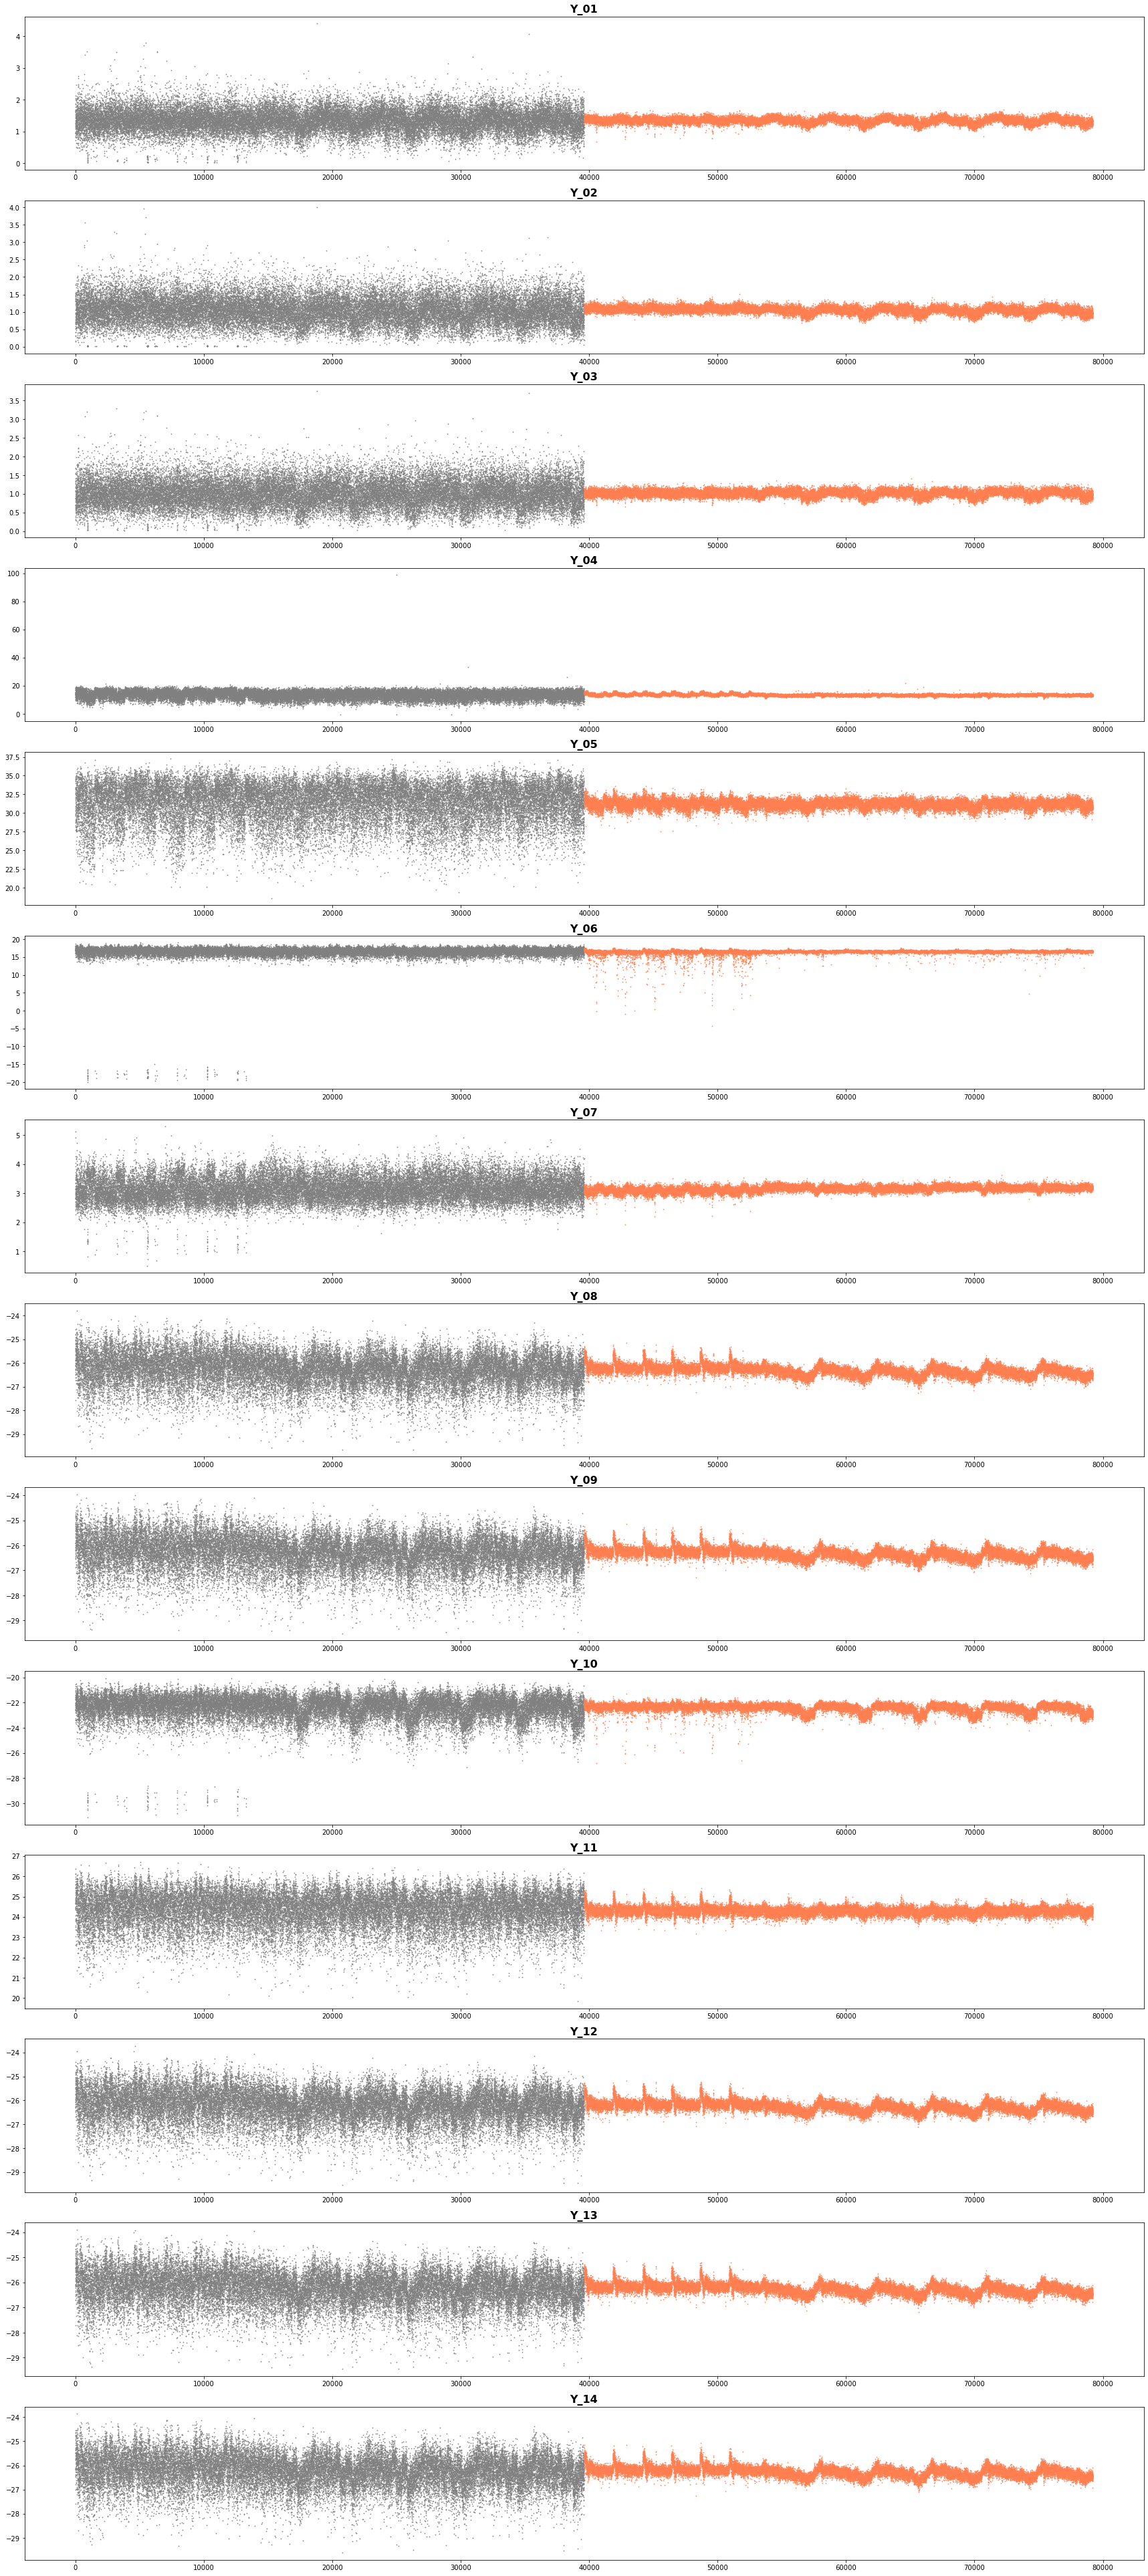

In [7]:
visual.show_pred(origin_train.filter(regex='Y'), y_pred)

In [8]:
for idx, col in enumerate(submission.columns):
    if col == 'ID':
        continue
    submission[col] = y_pred[:, idx-1]
    

submission.to_csv(f"submissions/{time.asctime().replace(':', '-')}.csv", index=False)
print('Done.')

Done.
